In [29]:
import os
import re
import json
import uuid
import subprocess
import networkx as nx

from typing import Optional, Dict, List, Set, Tuple, Any, IO

# --- Configuration ---
PROJECT_PATH: str = "tmp/adiprerepa/cs598APE-HW2"

# --- LSP Communication Utilities ---
def send_lsp_message(stdin: IO[bytes], msg: Dict[str, Any]) -> None:
    body = json.dumps(msg)
    header = f"Content-Length: {len(body)}\r\n\r\n"
    stdin.write(header.encode())
    stdin.write(body.encode())
    stdin.flush()

def read_lsp_message(stdout: IO[bytes]) -> Dict[str, Any]:
    headers = {}
    while True:
        line = stdout.readline().decode().strip()
        if not line:
            break
        key, value = line.split(": ")
        headers[key] = value

    content_length = int(headers["Content-Length"])
    content = stdout.read(content_length).decode()
    return json.loads(content)

# --- Function Lookup and Qualification Utilities ---
def get_definition(file_path: str, line: int, character: int, stdin: IO[bytes], stdout: IO[bytes]) -> Optional[List[Dict[str, Any]]]:
    request_id = str(uuid.uuid4())
    send_lsp_message(stdin, {
        "jsonrpc": "2.0",
        "id": request_id,
        "method": "textDocument/definition",
        "params": {
            "textDocument": {"uri": f"file://{os.path.abspath(file_path)}"},
            "position": {"line": line, "character": character}
        }
    })
    while True:
        response = read_lsp_message(stdout)
        if response.get("id") == request_id:
            return response.get("result")

def get_fully_qualified_name(uri: str, line: int, char: int, stdin: IO[bytes], stdout: IO[bytes]) -> Optional[str]:
    request_id = str(uuid.uuid4())
    send_lsp_message(stdin, {
        "jsonrpc": "2.0",
        "id": request_id,
        "method": "textDocument/hover",
        "params": {
            "textDocument": {"uri": uri},
            "position": {"line": line, "character": char}
        }
    })
    while True:
        response = read_lsp_message(stdout)
        if response.get("id") == request_id:
            break

    result = response.get("result")
    if result is None:
        return None

    contents = result.get("contents") if isinstance(result, dict) else None

    if isinstance(contents, dict):
        value = contents.get("value", "")
    elif isinstance(contents, list) and contents and isinstance(contents[0], dict):
        value = contents[0].get("value", "")
    else:
        value = ""

    match = re.search(r'([\w:~]+::)?([\w:~]+)\s*(<[^>]*>)?\s*\(', value)
    fallback_name = "unknown"
    if match:
        if match.group(1):
            return match.group(1).rstrip(':') + "::" + match.group(2)
        fallback_name = match.group(2)
    else:
        fallback_name = value

    request_id = str(uuid.uuid4())
    send_lsp_message(stdin, {
        "jsonrpc": "2.0",
        "id": request_id,
        "method": "textDocument/documentSymbol",
        "params": {"textDocument": {"uri": uri}}
    })
    while True:
        response = read_lsp_message(stdout)
        if response.get("id") == request_id:
            break

    def search(symbols: List[Dict[str, Any]], line: int, char: int, path: str = "") -> Optional[str]:
        for s in symbols:
            name = s["name"]
            s_range = s.get("range") or s.get("location", {}).get("range")
            if not s_range:
                continue
            start, end = s_range["start"], s_range["end"]
            if (start["line"] <= line <= end["line"] and
                (line != start["line"] or char >= start["character"]) and
                (line != end["line"] or char <= end["character"])):
                qualified = f"{path}::{name}" if path else name
                if "children" in s:
                    deeper = search(s["children"], line, char, qualified)
                    if deeper:
                        return deeper
                return qualified
        return path or None

    prefix = search(response.get("result", []), line, char)
    return f"{prefix}::{fallback_name}" if prefix else fallback_name

# --- Recursive Graph Builder ---
def scan_file(file_path: str, G: nx.DiGraph, visited: Set[str], proc: subprocess.Popen) -> None:
    abs_path = os.path.abspath(file_path)
    if abs_path in visited or not os.path.exists(abs_path) or not os.access(abs_path, os.W_OK):
        return

    visited.add(abs_path)

    with open(file_path, 'r') as f:
        code = f.read()
        lines = code.splitlines()
        send_lsp_message(proc.stdin, {
            "jsonrpc": "2.0",
            "method": "textDocument/didOpen",
            "params": {
                "textDocument": {
                    "uri": f"file://{abs_path}",
                    "languageId": "cpp",
                    "version": 1,
                    "text": code
                }
            }
        })

    for i, line in enumerate(lines):
        for match in re.finditer(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\s*\(', line):
            col = match.start(1)
            callee = match.group(1)

            if re.match(r'\b\S+\s+%s\s*\(' % callee, line.strip()):
                continue

            result = get_definition(file_path, i, col, proc.stdin, proc.stdout)
            if not result:
                continue

            caller = get_fully_qualified_name(f"file://{abs_path}", i, col, proc.stdin, proc.stdout)
            if not caller:
                continue

            for loc in result:
                uri = loc["uri"]
                def_file = uri.replace("file://", "")
                def_line = loc["range"]["start"]["line"]
                def_char = loc["range"]["start"]["character"]
                callee_func = get_fully_qualified_name(uri, def_line, def_char, proc.stdin, proc.stdout) or callee

                if caller != callee_func:
                    G.add_edge(caller, callee_func)

                if os.path.exists(def_file) and os.access(def_file, os.W_OK):
                    scan_file(def_file, G, visited, proc)

# --- File Collector ---
def collect_cpp_files(project_path: str) -> List[str]:
    cpp_files = []
    for root, _, files in os.walk(project_path):
        for file in files:
            if file.endswith((".cpp", ".cc", ".cxx", ".h", ".c")):
                cpp_files.append(os.path.join(root, file))
    return cpp_files

# --- Main Execution ---
def main() -> nx.DiGraph:
    proc = subprocess.Popen(
        ["clangd", f"--compile-commands-dir={PROJECT_PATH}"],
        stdin=subprocess.PIPE, stdout=subprocess.PIPE
    )

    send_lsp_message(proc.stdin, {
        "jsonrpc": "2.0",
        "id": 0,
        "method": "initialize",
        "params": {
            "processId": None,
            "rootUri": f"file://{os.path.abspath(PROJECT_PATH)}",
            "capabilities": {}
        }
    })
    read_lsp_message(proc.stdout)

    send_lsp_message(proc.stdin, {
        "jsonrpc": "2.0",
        "method": "initialized",
        "params": {}
    })

    G: nx.DiGraph = nx.DiGraph()
    visited_files: Set[str] = set()

    cpp_files = collect_cpp_files(PROJECT_PATH)
    for file_path in cpp_files:
        scan_file(file_path, G, visited_files, proc)

    proc.kill()
    return G

G = main()
print("Function Nodes:")
for node in G.nodes():
    print(node)

print("\nFunction Call Edges:")
for caller, callee in G.edges():
    print(f"{caller} -> {callee}")

I[20:22:40.479] Ubuntu clangd version 18.1.3 (1ubuntu1)
I[20:22:40.479] Features: linux+grpc
I[20:22:40.479] PID: 2818809
I[20:22:40.479] Working directory: /home/ayuram/pesquared
I[20:22:40.479] argv[0]: clangd
I[20:22:40.479] argv[1]: --compile-commands-dir=tmp/adiprerepa/cs598APE-HW2
I[20:22:40.479] Starting LSP over stdin/stdout
I[20:22:40.479] <-- initialize(0)
I[20:22:40.483] --> reply:initialize(0) 3 ms
I[20:22:40.483] <-- initialized
I[20:22:40.483] <-- textDocument/didOpen
I[20:22:40.483] <-- textDocument/definition("f585cc5d-b474-4ce9-8ebc-d5b4b00ec937")
I[20:22:40.484] Failed to find compilation database for /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-HW2/philox_example.cpp
I[20:22:40.484] ASTWorker building file /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-HW2/philox_example.cpp version 1 with command clangd fallback
[/home/ayuram/pesquared/tmp/adiprerepa/cs598APE-HW2]
/usr/lib/llvm-18/bin/clang -resource-dir=/usr/lib/llvm-18/lib/clang/18 -- /home/ayuram/pesquared/tmp/

Function Nodes:
philox_oneround::a
multiply_high_low::a
philox_next4::counter
philox_oneround::counter
philox_next4::count
philox_skip::count
philox_next4::key
philox_raisekey::key
myrand::philox_reset
philox_reset::philox_reset
myrand::out
philox_next4::out
main::printf
printf
main::uint64_t
myrand::uint64_t
main::count
utils::is_open
is_open
utils::class runtime_error
provided by <stdexcept>

// In namespace std
class runtime_error : public exception {}
runtime_error
utils::function getline
provided by <string>

→ basic_istream<char, char_traits<char>> &
Parameters:
- basic_istream<char, char_traits<char>> & __is
- basic_string<char, char_traits<char>, allocator<char>> & __str

// In namespace std
template <>
inline basic_istream<char, char_traits<char>> &
getline<char, std::char_traits<char>, std::allocator<char>>(
    basic_istream<char, char_traits<char>> &__is,
    basic_string<char, char_traits<char>, allocator<char>> &__str)
getline
utils::function getline
provided by <string>


I[20:22:42.862] Built preamble of size 5476216 for file /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-HW2/include/genetic.h version 1 in 0.18 seconds
I[20:22:42.867] --> textDocument/publishDiagnostics
I[20:22:42.868] --> reply:textDocument/definition("8dc28296-ddad-4b41-b7e8-87012d12a4ba") 187 ms
I[20:22:42.868] <-- textDocument/definition("3a359302-050f-4dcf-8f8d-50bd9b939583")
I[20:22:42.868] --> reply:textDocument/definition("3a359302-050f-4dcf-8f8d-50bd9b939583") 0 ms
I[20:22:42.868] <-- textDocument/definition("d4f40eb2-f5ca-4c80-b999-e846a4d86749")
I[20:22:42.868] --> reply:textDocument/definition("d4f40eb2-f5ca-4c80-b999-e846a4d86749") 0 ms
I[20:22:42.869] <-- textDocument/definition("297208ed-1402-45fd-a096-180661cdaf00")
I[20:22:42.869] --> reply:textDocument/definition("297208ed-1402-45fd-a096-180661cdaf00") 0 ms
I[20:22:42.869] <-- textDocument/definition("f0079793-ca04-4cf9-83d1-549599389db9")
I[20:22:42.869] --> reply:textDocument/definition("f0079793-ca04-4cf9-83d1-5495

Function Graph (caller -> callee):
philox_oneround::a -> multiply_high_low::a
philox_next4::counter -> philox_oneround::counter
philox_next4::count -> philox_skip::count
philox_next4::key -> philox_raisekey::key
myrand::philox_reset -> philox_reset::philox_reset
myrand::out -> philox_next4::out
main::printf -> printf
main::uint64_t -> myrand::uint64_t
main::count -> philox_skip::count
utils::is_open -> is_open
utils::unknown -> runtime_error
utils::unknown -> getline
utils::unknown -> iota
utils::__x -> push_back
utils::__str -> stof
utils::reference -> back
utils::pop_back -> pop_back
utils::empty -> empty
utils::size_type -> size
utils::iterator -> begin
utils::iterator -> end
run_symbolic_regression::filename -> utils::filename
run_symbolic_regression::size_type -> size
run_symbolic_regression::unknown -> utils::train_test_split
run_symbolic_regression::flatten_column_major -> utils::flatten_column_major
run_symbolic_regression::insertionSortPrograms -> insertionSortPrograms::insert

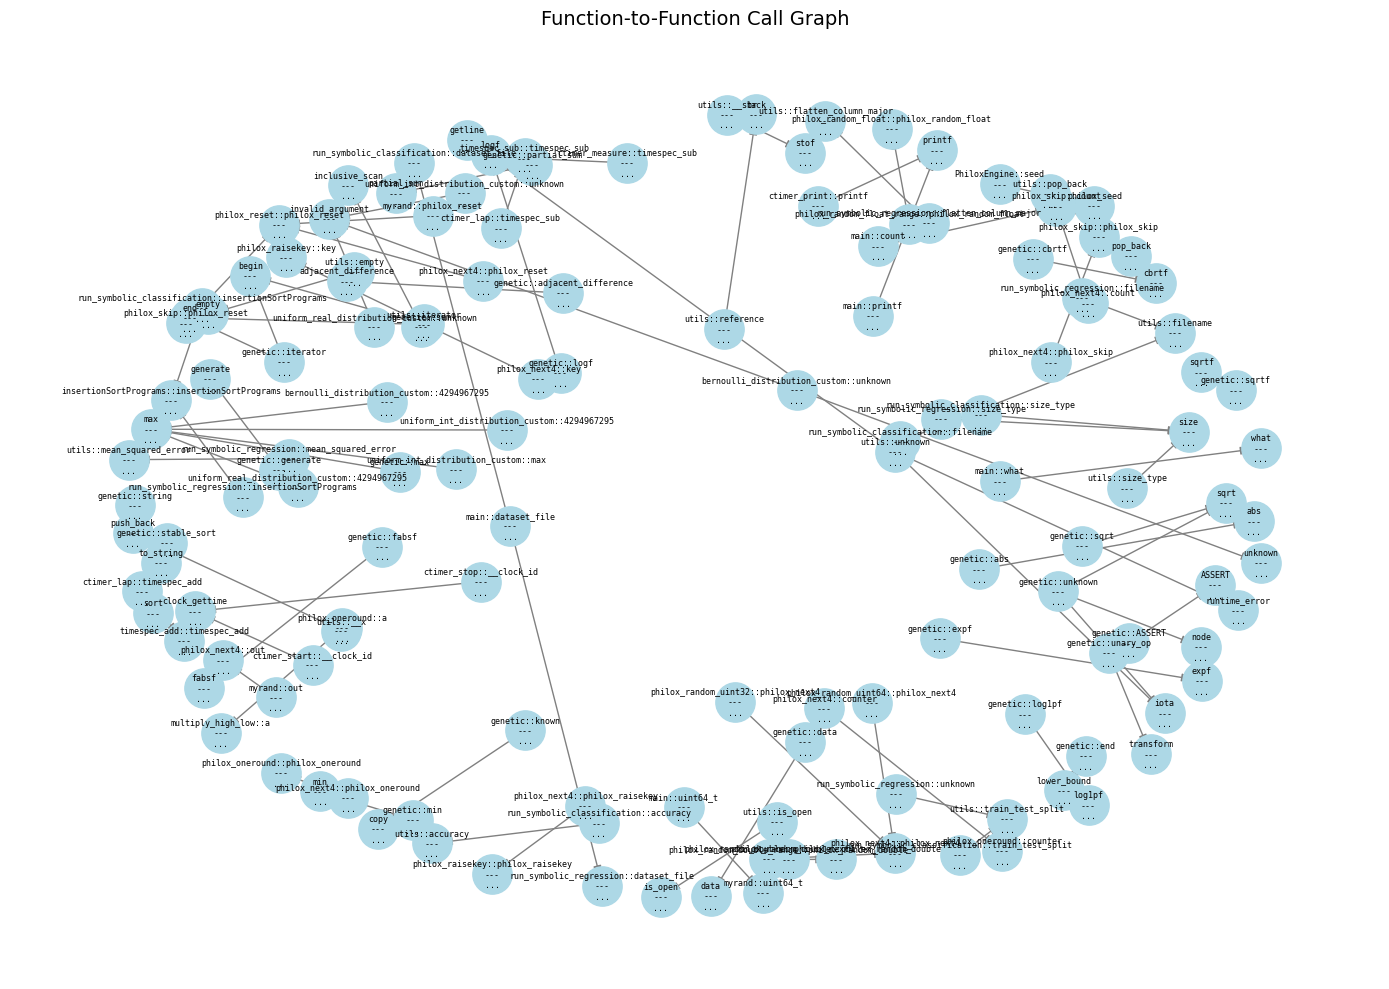

In [28]:
import matplotlib.pyplot as plt

print("Function Graph (caller -> callee):")
for u, v in G.edges():
    print(f"{u} -> {v}")

# Visualization with matplotlib
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=100)
labels = {node: f"{node}\n---\n{G.nodes[node].get('body', '')[:150]}..." for node in G.nodes}
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=12, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_family="monospace")

plt.title("Function-to-Function Call Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()